In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
import xgboost as xgb

# 데이터 로드

In [2]:
curr_dir = os.getcwd()

forders_tr = os.listdir(curr_dir+"\\data")

data = pd.read_csv(os.path.join(curr_dir+"\\data\\")+forders_tr[0])
data = data.drop(data.columns[0], axis=1)
data

submission = pd.read_csv('2-1_검증데이터셋.csv')
submission1 = submission.copy()          

# 전처리

In [121]:
soil = pd.read_csv('OBS_AAOS_TIM_20220802210224.csv', encoding='cp949')       # 외부 데이터 로드
stn = list(set(soil['지점'].values))

soil_df1 = []      # 일시 포함된 데이터 프레임
for i in range(len(stn)):
    df = soil[soil['지점']==stn[i]]
    df = df.reset_index()
    df = df.drop('index', axis=1)
    soil_df1.append(df)

    
soil_df = []        # 일시가 제외된 데이터 프레임 (추합을 위해)
for i in range(len(stn)):
    df = soil[soil['지점']==stn[i]]
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df = df.drop(['지점', '지점명', '일시'], axis=1)   
    soil_df.append(df) 
  
day = pd.date_range('2021-11-26', periods=95*24+20*24, freq='1H')    # 21.11.26~22.03.20
day
day1 = pd.DataFrame(day)
day1.columns = ['일자']
day1
day1.to_csv('day_real.csv', index=False)


for i in range(len(stn)):
    df = soil[soil['지점']==stn[i]]
    df.to_csv(os.path.join(str(stn[i])+'.csv'), index=False)   # 관측소마다.csv 파일로 저장

In [251]:
# 관측소마다 일시(일자) 통합을 위해 'day_real'파일과 위에서 저장된 모든 관측소에 대해 엑셀 VLOOKUP 함수 이용하여 
# 중간에 비어 있는 일시를 채워주는 작업 후, 각 파일을 _1.csv 파일로 저장

soil_df2 = []
for i in range(len(stn)):
    df = pd.read_csv(os.path.join(str(stn[i])+'_1.csv'), encoding='cp949')
    df = df.drop('일자', axis=1)
    df = df.fillna(0)
    soil_df2.append(df)



soil_df3 = soil_df2[0].copy()
for i in range(len(soil_df[0].columns)):
    soil_df2[0][soil_df2[0].columns[i]] = 0

# 각 관측소마다 평균 내기 (추합)
for i in range(1, len(soil_df2)):
    soil_df3 = soil_df3 + soil_df2[i]
soil_df3 = soil_df3/len(soil_df2)
soil_df3['일자'] = pd.date_range('2021-11-26', periods=95*24+20*24, freq='1H')


# 제공 데이터와의 통합을 위해 제공 데이터에 없는 일시를 외부 데이터에서 제외시킴
d1 = soil_df3[soil_df3['일자'] == '2021-12-22 0:00'].index[0]
for i in range(d1, d1+24*3):
    soil_df3 = soil_df3.drop(i,axis=0)

d2 = soil_df3[soil_df3['일자'] == '2022-03-01 0:00'].index[0]
for i in range(d2, d2+24*3):
    soil_df3 = soil_df3.drop(i,axis=0)
    
d3 = soil_df3[soil_df3['일자'] == '2022-03-14 0:00'].index[0]
for i in range(d3, d3+24):
    soil_df3 = soil_df3.drop(i,axis=0)
    
d4 = soil_df3[soil_df3['일자'] == '2022-03-16 0:00'].index[0]
for i in range(d4, d4+24*2):
    soil_df3 = soil_df3.drop(i,axis=0)

soil_df3 = soil_df3.reset_index()
soil_df3 = soil_df3.drop('index', axis=1)

# 제공 데이터와 외부 데이터 통합 (시간 데이터 제외 모든 열)
col = ['smart_farm.insolation', 'smart_farm.out_tmperature',\
       'smart_farm.out_humidity', 'smart_farm.wind_speed',\
       'smart_farm.wind_direction', 'smart_farm.in_tmperature',\
       'smart_farm.in_humidity', 'smart_farm.shield_light_h',\
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',\
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',\
       'smart_farm.ceiling', 'smart_farm.floating_fan',\
       'smart_farm.fan_coil_b_site',\
       'smart_farm.ventilation_temperature_control',\
       'smart_farm.heating_temperature_set_up']          

data_ = pd.DataFrame()
for k in tqdm(range(len(col))):
    h = []
    for i in range(int(len(data)/60)):      # 분 -> 시간 단위 바꾸기 위해
        h.append(np.mean(data[col[k]][60*i:60*(i+1)]))
    data_[col[k]] = h
    
h1 = []
for i in range(int(len(data)/60)):
    h1.append(np.sum(data['smart_farm.heat_supply'][60*i:60*(i+1)]))
data_['smart_farm.heat_supply'] = h1



real_data = pd.concat([soil_df3, data_], axis=1)
real_data1 = pd.concat([real_data[real_data.columns[4]], real_data[real_data.columns[:4]], real_data[real_data.columns[5:]]], axis=1)
real_data1 = real_data1.reset_index()
real_data1 = real_data1.drop('index', axis=1)
real_data1 = real_data1.dropna(subset = ['일자'])
real_data1.to_csv('real_data_통합.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s]


In [262]:
# 위에서 저장한 'real_data_통합' 파일과 'day_real' 파일 이용하여
# 엑셀 VLOOKUP 함수 이용하여 21.11.26부터 22.03.20까지 비어 일자 채운 후, 다시 'real_data_결측' 파일로 저장

pre = pd.read_csv('real_data_결측.csv', encoding='cp949')
pre1 = pre.interpolate(method ='linear')      
pre1 = pre1.dropna(subset = ['일자'])
pre1.to_csv('real_data_최종.csv', index=False)  # 최종 전처리 파일(결측치 제거한)

real1 = pd.read_csv('real_data_최종.csv', encoding='utf-8')
real1

# 자른 이유? 20개를 추출하기 위해 일자 슬라이싱이 필요함.
training = real1[:-504]
testing = real1[-504:]
testing = testing.reset_index()
testing = testing.drop('index', axis=1)

In [3]:
real1 = pd.read_csv('real_data_최종.csv', encoding='utf-8')
real1

# 자른 이유? 20개를 추출하기 위해 일자 슬라이싱이 필요함.
training = real1[:-504]
testing = real1[-504:]
testing = testing.reset_index()
testing = testing.drop('index', axis=1)

# 모델 1

In [6]:
X = training.drop(['10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',\
       '50CM 정시 토양수분(%)','일자','smart_farm.heat_supply'], axis=1)
y = training[['smart_farm.heat_supply']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)  

X_test= testing.drop(['10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',\
       '50CM 정시 토양수분(%)','일자','smart_farm.heat_supply'], axis=1)


xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)


[0]	validation_0-rmse:24.82131
[1]	validation_0-rmse:24.63866
[2]	validation_0-rmse:24.44326
[3]	validation_0-rmse:24.25303
[4]	validation_0-rmse:24.06976
[5]	validation_0-rmse:23.88173
[6]	validation_0-rmse:23.69872
[7]	validation_0-rmse:23.51493
[8]	validation_0-rmse:23.32680
[9]	validation_0-rmse:23.14683
[10]	validation_0-rmse:22.96639
[11]	validation_0-rmse:22.79242
[12]	validation_0-rmse:22.61644
[13]	validation_0-rmse:22.44263
[14]	validation_0-rmse:22.27307
[15]	validation_0-rmse:22.10528
[16]	validation_0-rmse:21.93970
[17]	validation_0-rmse:21.77386
[18]	validation_0-rmse:21.61428
[19]	validation_0-rmse:21.45744
[20]	validation_0-rmse:21.30077
[21]	validation_0-rmse:21.15488
[22]	validation_0-rmse:21.00137
[23]	validation_0-rmse:20.85111
[24]	validation_0-rmse:20.70420
[25]	validation_0-rmse:20.55579
[26]	validation_0-rmse:20.40326
[27]	validation_0-rmse:20.25868


C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:20.12039
[29]	validation_0-rmse:19.98078
[30]	validation_0-rmse:19.83968
[31]	validation_0-rmse:19.70220
[32]	validation_0-rmse:19.57157
[33]	validation_0-rmse:19.43832
[34]	validation_0-rmse:19.30174
[35]	validation_0-rmse:19.16652
[36]	validation_0-rmse:19.03972
[37]	validation_0-rmse:18.90958
[38]	validation_0-rmse:18.78345
[39]	validation_0-rmse:18.65560
[40]	validation_0-rmse:18.53193
[41]	validation_0-rmse:18.41315
[42]	validation_0-rmse:18.29935
[43]	validation_0-rmse:18.18892
[44]	validation_0-rmse:18.07107
[45]	validation_0-rmse:17.96299
[46]	validation_0-rmse:17.85350
[47]	validation_0-rmse:17.74113
[48]	validation_0-rmse:17.63602
[49]	validation_0-rmse:17.52906
[50]	validation_0-rmse:17.42706
[51]	validation_0-rmse:17.31760
[52]	validation_0-rmse:17.21462
[53]	validation_0-rmse:17.11438
[54]	validation_0-rmse:17.01521
[55]	validation_0-rmse:16.91281
[56]	validation_0-rmse:16.80944
[57]	validation_0-rmse:16.70747
[58]	validation_0-rmse:16.60692
[59]	val

[279]	validation_0-rmse:10.61439
[280]	validation_0-rmse:10.61275
[281]	validation_0-rmse:10.60837
[282]	validation_0-rmse:10.60901
[283]	validation_0-rmse:10.60762
[284]	validation_0-rmse:10.60581
[285]	validation_0-rmse:10.60176
[286]	validation_0-rmse:10.59807
[287]	validation_0-rmse:10.59220
[288]	validation_0-rmse:10.58782
[289]	validation_0-rmse:10.59091
[290]	validation_0-rmse:10.59111
[291]	validation_0-rmse:10.58866
[292]	validation_0-rmse:10.58463
[293]	validation_0-rmse:10.58212
[294]	validation_0-rmse:10.58509
[295]	validation_0-rmse:10.58298
[296]	validation_0-rmse:10.58428
[297]	validation_0-rmse:10.57969
[298]	validation_0-rmse:10.57772
[299]	validation_0-rmse:10.58057
[300]	validation_0-rmse:10.58046
[301]	validation_0-rmse:10.57670
[302]	validation_0-rmse:10.57654
[303]	validation_0-rmse:10.57679
[304]	validation_0-rmse:10.57492
[305]	validation_0-rmse:10.57376
[306]	validation_0-rmse:10.57285
[307]	validation_0-rmse:10.57302
[308]	validation_0-rmse:10.57394
[309]	vali

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

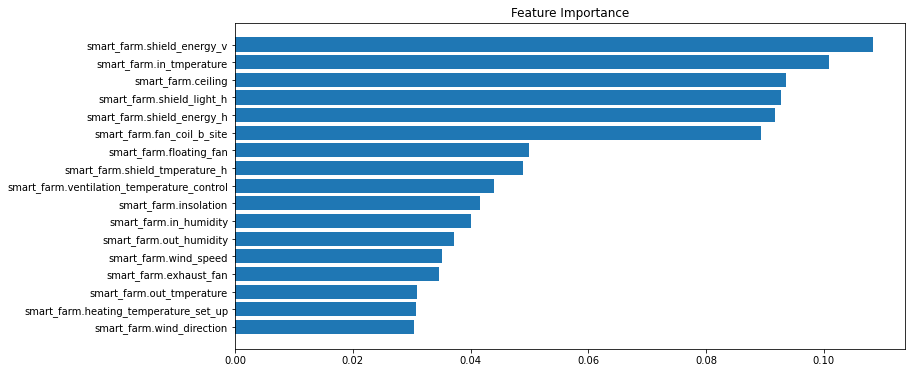

In [9]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [11]:
pred_ = xgb_model.predict(X_test)
h1 = []
for i in range(int(len(pred_)/24)):
    h1.append(np.sum(pred_[24*i:24*(i+1)]))
h1
# 4~13, 18~20
h1.insert(0,0)     # 한 번만 클릭!
h1

h11 = h1[4:14] + h1[18:21]
h11
submission1['heat_supply_day1'] = h11
submission1 

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,721.166077,NaN
1,2022,3,5,418.576782,NaN
2,2022,3,6,423.510773,NaN
3,2022,3,7,477.273254,NaN
4,2022,3,8,678.531982,NaN
5,2022,3,9,457.900299,NaN
6,2022,3,10,436.119995,NaN
7,2022,3,11,390.061554,NaN
8,2022,3,12,403.006531,NaN
9,2022,3,13,310.477051,NaN


# 모델 2(절감 모델)

In [13]:
X = training.drop(['일자','smart_farm.heat_supply'], axis=1)
y = training[['smart_farm.heat_supply']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)   # shuffle은 안 됨. 시간적순서라

X_test = testing.drop(['일자','smart_farm.heat_supply'], axis=1)


xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)
xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)

[0]	validation_0-rmse:24.81769
[1]	validation_0-rmse:24.63455
[2]	validation_0-rmse:24.43749
[3]	validation_0-rmse:24.25562
[4]	validation_0-rmse:24.07525
[5]	validation_0-rmse:23.89863
[6]	validation_0-rmse:23.71866
[7]	validation_0-rmse:23.54093
[8]	validation_0-rmse:23.35587
[9]	validation_0-rmse:23.17717
[10]	validation_0-rmse:23.00443
[11]	validation_0-rmse:22.83069
[12]	validation_0-rmse:22.65529
[13]	validation_0-rmse:22.48630
[14]	validation_0-rmse:22.32016
[15]	validation_0-rmse:22.15201
[16]	validation_0-rmse:22.00136
[17]	validation_0-rmse:21.83710
[18]	validation_0-rmse:21.68130
[19]	validation_0-rmse:21.52466
[20]	validation_0-rmse:21.36745
[21]	validation_0-rmse:21.21332
[22]	validation_0-rmse:21.06087
[23]	validation_0-rmse:20.90584
[24]	validation_0-rmse:20.75590
[25]	validation_0-rmse:20.60665
[26]	validation_0-rmse:20.47943
[27]	validation_0-rmse:20.33677
[28]	validation_0-rmse:20.19206
[29]	validation_0-rmse:20.06036
[30]	validation_0-rmse:19.91690
[31]	validation_0-

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:19.25700
[36]	validation_0-rmse:19.13547
[37]	validation_0-rmse:19.00966
[38]	validation_0-rmse:18.88698
[39]	validation_0-rmse:18.76297
[40]	validation_0-rmse:18.64656
[41]	validation_0-rmse:18.52934
[42]	validation_0-rmse:18.41184
[43]	validation_0-rmse:18.30305
[44]	validation_0-rmse:18.18634
[45]	validation_0-rmse:18.08015
[46]	validation_0-rmse:17.97074
[47]	validation_0-rmse:17.85505
[48]	validation_0-rmse:17.74370
[49]	validation_0-rmse:17.63693
[50]	validation_0-rmse:17.53860
[51]	validation_0-rmse:17.43608
[52]	validation_0-rmse:17.32803
[53]	validation_0-rmse:17.22387
[54]	validation_0-rmse:17.11898
[55]	validation_0-rmse:17.02255
[56]	validation_0-rmse:16.91732
[57]	validation_0-rmse:16.81588
[58]	validation_0-rmse:16.72169
[59]	validation_0-rmse:16.62816
[60]	validation_0-rmse:16.53486
[61]	validation_0-rmse:16.43985
[62]	validation_0-rmse:16.34934
[63]	validation_0-rmse:16.26623
[64]	validation_0-rmse:16.17550
[65]	validation_0-rmse:16.10928
[66]	val

[286]	validation_0-rmse:10.99809
[287]	validation_0-rmse:10.99866
[288]	validation_0-rmse:10.99819
[289]	validation_0-rmse:10.99355
[290]	validation_0-rmse:10.98822
[291]	validation_0-rmse:10.98846
[292]	validation_0-rmse:10.98880
[293]	validation_0-rmse:10.99112
[294]	validation_0-rmse:10.99026
[295]	validation_0-rmse:10.98868
[296]	validation_0-rmse:10.98812
[297]	validation_0-rmse:10.98917
[298]	validation_0-rmse:10.99089
[299]	validation_0-rmse:10.98742
[300]	validation_0-rmse:10.98337
[301]	validation_0-rmse:10.98922
[302]	validation_0-rmse:10.99115
[303]	validation_0-rmse:10.99098
[304]	validation_0-rmse:10.98503
[305]	validation_0-rmse:10.98363
[306]	validation_0-rmse:10.97835
[307]	validation_0-rmse:10.97585
[308]	validation_0-rmse:10.97605
[309]	validation_0-rmse:10.97554
[310]	validation_0-rmse:10.97389
[311]	validation_0-rmse:10.97674
[312]	validation_0-rmse:10.97672
[313]	validation_0-rmse:10.97546
[314]	validation_0-rmse:10.97845
[315]	validation_0-rmse:10.97378
[316]	vali

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE

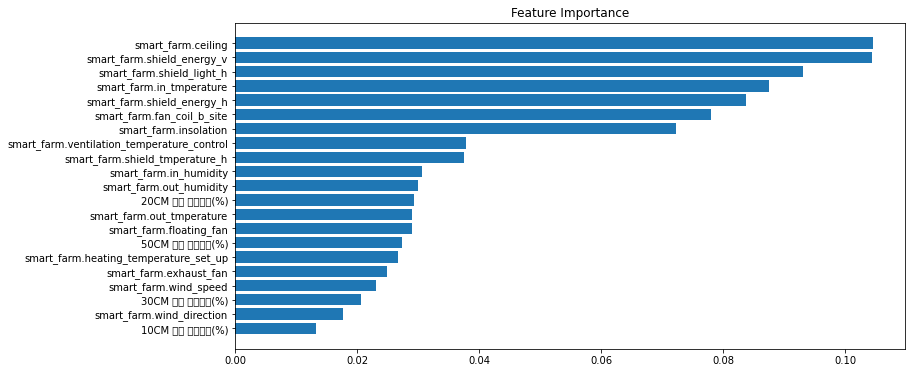

In [14]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [16]:
pred_2 = xgb_model.predict(X_test)
h2 = []
for i in range(int(len(pred_2)/24)):
    h2.append(np.sum(pred_2[24*i:24*(i+1)]))
h2
# 4~13, 18~20
h2.insert(0,0)     # 한 번만 클릭!
h2

h22 = h2[4:14] + h2[18:21]
h22
submission1['heat_supply_day2'] = h22
submission1 

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,721.166077,700.616211
1,2022,3,5,418.576782,384.007935
2,2022,3,6,423.510773,413.733704
3,2022,3,7,477.273254,421.669128
4,2022,3,8,678.531982,639.186401
5,2022,3,9,457.900299,428.463135
6,2022,3,10,436.119995,391.424927
7,2022,3,11,390.061554,429.255859
8,2022,3,12,403.006531,417.185486
9,2022,3,13,310.477051,360.388428


In [17]:
submission1.to_csv('220224_최종코드틀_XGB.csv', index=False) 